<a href="https://colab.research.google.com/github/serskinek/seed-labs/blob/master/Copy_of_assignment_DecisionTree_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling Intrusion Detection: Analysis of a Feature Selection Mechanism

## Method Description

### Step 1: Data preprocessing:
All features are made numerical using one-Hot-encoding. The features are scaled to avoid features with large values that may weigh too much in the results.

### Step 2: Feature Selection:
Eliminate redundant and irrelevant data by selecting a subset of relevant features that fully represents the given problem.
Univariate feature selection with ANOVA F-test. This analyzes each feature individually to detemine the strength of the relationship between the feature and labels. Using SecondPercentile method (sklearn.feature_selection) to select features based on percentile of the highest scores.
When this subset is found: Recursive Feature Elimination (RFE) is applied.

### Step 4: Build the model:
Decision tree model is built.

### Step 5: Prediction & Evaluation (validation):
Using the test data to make predictions of the model.
Multiple scores are considered such as:accuracy score, recall, f-measure, confusion matrix.
perform a 10-fold cross-validation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Version Check

In [ ]:
import pandas as pd
import numpy as np
import sys
import sklearn
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

1.5.3
1.23.5
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
1.2.2


## Load the Dataset

In [ ]:
# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# KDDTrain+_2.csv & KDDTest+_2.csv are the datafiles without the last column about the difficulty score
# these have already been removed.
df = pd.read_csv("/Edited - csv_result-KDDTrain+_20Percent(1).csv", header=None, names = col_names)
df_test = pd.read_csv("/Edited- csv_result-KDDTest-21.csv", header=None, names = col_names)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (25192, 42)
Dimensions of the Test set: (11850, 42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Sample view of the training dataset

In [ ]:
# first five rows
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
1,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
2,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
3,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
4,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
5,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## Statistical Summary

In [ ]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Label Distribution of Training and Test set

In [ ]:
print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
normal     13449
anomaly    11743
Name: label, dtype: int64

Label distribution Test set:
anomaly    9698
normal     2152
Name: label, dtype: int64


# Step 1: Data preprocessing:
One-Hot-Encoding (one-of-K) is used to to transform all categorical features into binary features.
Requirement for One-Hot-encoding:
"The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features. The output will be a sparse matrix where each column corresponds to one possible value of one feature. It is assumed that input features take on values in the range [0, n_values)."

Therefore the features first need to be transformed with LabelEncoder, to transform every category to a number.

## Identify categorical features

In [ ]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 66 categories
Feature 'flag' has 11 categories
Feature 'label' has 2 categories

Distribution of categories in service:
http        8003
private     4351
domain_u    1820
smtp        1449
ftp_data    1396
Name: service, dtype: int64


In [ ]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 62 categories
Feature 'flag' has 11 categories
Feature 'label' has 2 categories


### Conclusion: Need to make dummies for all categories as the distribution is fairly even. In total: 3+70+11=84 dummies.
### Comparing the results shows that the Test set has fewer categories (6), these need to be added as empty columns.

In [ ]:
df.select_dtypes(include=["object"])

,protocol_type,service,flag,label
1,tcp,ftp_data,SF,normal
2,udp,other,SF,normal
3,tcp,private,S0,anomaly
4,tcp,http,SF,normal
5,tcp,http,SF,normal
...,...,...,...,...
25188,tcp,exec,RSTO,anomaly
25189,tcp,ftp_data,SF,anomaly
25190,tcp,private,REJ,anomaly
25191,tcp,nnsp,S0,anomaly


# LabelEncoder

### Insert categorical features into a 2D numpy array

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag']
 # Get the categorical values into a 2D numpy array
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
1,tcp,ftp_data,SF
2,udp,other,SF
3,tcp,private,S0
4,tcp,http,SF
5,tcp,http,SF


### Make column names for dummies

In [ ]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_hostnames', 'service_http', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'service_rje', 'service_shell', 'service_smtp', 'service_sql

## Transform categorical features into numbers using LabelEncoder()

In [ ]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
1              1       19     9
2              2       41     9
3              1       46     5
4              1       22     9
5              1       22     9


# One-Hot-Encoding

In [ ]:
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Add 6 missing categories from train set to test set

In [ ]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_http_8001',
 'service_red_i',
 'service_printer',
 'service_urh_i',
 'service_rje']

In [ ]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(11850, 81)

## Join encoded categorical dataframe with the non-categorical dataframe

In [ ]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(25192, 119)
(11850, 120)


# Split Dataset into 4 datasets for every attack category
## Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.
## Replace labels column with new labels column
## Make new datasets


In [ ]:
# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
# #newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
#                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
#                          ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
#                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# #newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
#                            'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
#                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
#                            'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

newlabeldf=labeldf.replace({ 'normal' : 0, 'anomaly' : 1})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'anomaly' : 1})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

1    0
2    0
3    1
4    0
5    0
Name: label, dtype: int64


In [ ]:
to_drop_DoS = [2,3,4]
# to_drop_Probe = [1,3,4]
# to_drop_R2L = [1,2,4]
# to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
# Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
# R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
# U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
# Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
# R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
# U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
# print('Dimensions of Probe:' ,Probe_df.shape)
# print('Dimensions of R2L:' ,R2L_df.shape)
# print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
# print('Dimensions of Probe:' ,Probe_df_test.shape)
# print('Dimensions of R2L:' ,R2L_df_test.shape)
# print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (25192, 119)
Test:
Dimensions of DoS: (11850, 120)


# Step 2: Feature Scaling:

In [ ]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
# X_Probe = Probe_df.drop('label',1)
# Y_Probe = Probe_df.label
# X_R2L = R2L_df.drop('label',1)
# Y_R2L = R2L_df.label
# X_U2R = U2R_df.drop('label',1)
# Y_U2R = U2R_df.label
# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
# X_Probe_test = Probe_df_test.drop('label',1)
# Y_Probe_test = Probe_df_test.label
# X_R2L_test = R2L_df_test.drop('label',1)
# Y_R2L_test = R2L_df_test.label
# X_U2R_test = U2R_df_test.drop('label',1)
# Y_U2R_test = U2R_df_test.label

<ipython-input-30-44f228f04db4>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_DoS = DoS_df.drop('label',1)
<ipython-input-30-44f228f04db4>:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_DoS_test = DoS_df_test.drop('label',1)


### Save a list of feature names for later use (it is the same for every attack category). Column names are dropped at this stage.

In [ ]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

## Use StandardScaler() to scale the dataframes

In [ ]:
from sklearn import preprocessing
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS)
# scaler2 = preprocessing.StandardScaler().fit(X_Probe)
# X_Probe=scaler2.transform(X_Probe)
# scaler3 = preprocessing.StandardScaler().fit(X_R2L)
# X_R2L=scaler3.transform(X_R2L)
# scaler4 = preprocessing.StandardScaler().fit(X_U2R)
# X_U2R=scaler4.transform(X_U2R)
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test)
# scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
# X_Probe_test=scaler6.transform(X_Probe_test)
# scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
# X_R2L_test=scaler7.transform(X_R2L_test)
# scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
# X_U2R_test=scaler8.transform(X_U2R_test)

In [ ]:
np.isnan(X_DoS)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]])

### Check that the Standard Deviation is 1

In [ ]:
print(X_DoS[:-1, :].std(axis=0))

[1.00001959 1.00001985 1.00001982 1.00001985 1.00001968 1.00001985
 1.00001968 1.00001983 1.0000069  1.00001984 1.00001982 1.00001983
 1.00001984 1.00001983 1.00001984 1.00001981 0.         0.
 1.00001967 1.00001657 1.00001853 0.99996932 0.99996902 1.0000171
 1.00001709 1.00000168 1.00001844 1.00001707 1.00000921 1.00001277
 1.00000914 1.00001828 1.0000159  1.0000182  0.99996879 0.99996811
 1.0000169  1.00001707 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.   

In [ ]:
X_DoS = X_DoS[:-1, :]
Y_DoS = Y_DoS[:-1]

In [ ]:
(np.isnan(X_DoS[:, 89]).sum())

0

In [ ]:
X_DoS.std(axis=0)

array([1.00001959, 1.00001985, 1.00001982, 1.00001985, 1.00001968,
       1.00001985, 1.00001968, 1.00001983, 1.0000069 , 1.00001984,
       1.00001982, 1.00001983, 1.00001984, 1.00001983, 1.00001984,
       1.00001981, 0.        , 0.        , 1.00001967, 1.00001657,
       1.00001853, 0.99996932, 0.99996902, 1.0000171 , 1.00001709,
       1.00000168, 1.00001844, 1.00001707, 1.00000921, 1.00001277,
       1.00000914, 1.00001828, 1.0000159 , 1.0000182 , 0.99996879,
       0.99996811, 1.0000169 , 1.00001707, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [ ]:
# X_Probe.std(axis=0);
# X_R2L.std(axis=0);
# X_U2R.std(axis=0);

# Step 3: Feature Selection:

# 1. Univariate Feature Selection using ANOVA F-test

In [ ]:
#univariate feature selection with ANOVA F-test. using secondPercentile method, then RFE
#Scikit-learn exposes feature selection routines as objects that implement the transform method
#SelectPercentile: removes all but a user-specified highest scoring percentage of features
#f_classif: ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=10)
X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
X_newDoS.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [16 17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


(25191, 12)

### Get the features that were selected: DoS

In [ ]:
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_srv_rerror_rate']

In [ ]:
# X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
# X_newProbe.shape

### Get the features that were selected: Probe

In [ ]:
# true=selector.get_support()
# newcolindex_Probe=[i for i, x in enumerate(true) if x]
# newcolname_Probe=list( colNames[i] for i in newcolindex_Probe )
# newcolname_Probe

In [ ]:
# X_newR2L = selector.fit_transform(X_R2L,Y_R2L)
# X_newR2L.shape

### Get the features that were selected: R2L

In [ ]:
# true=selector.get_support()
# newcolindex_R2L=[i for i, x in enumerate(true) if x]
# newcolname_R2L=list( colNames[i] for i in newcolindex_R2L)
# newcolname_R2L

In [ ]:
# X_newU2R = selector.fit_transform(X_U2R,Y_U2R)
# X_newU2R.shape

### Get the features that were selected: U2R

In [ ]:
# true=selector.get_support()
# newcolindex_U2R=[i for i, x in enumerate(true) if x]
# newcolname_U2R=list( colNames[i] for i in newcolindex_U2R)
# newcolname_U2R

# Summary of features selected by Univariate Feature Selection

In [ ]:
print('Features selected for DoS:',newcolname_DoS)
print()
# print('Features selected for Probe:',newcolname_Probe)
# print()
# print('Features selected for R2L:',newcolname_R2L)
# print()
# print('Features selected for U2R:',newcolname_U2R)

Features selected for DoS: ['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate']



# 2. Recursive Feature Elimination for feature ranking (Option 1: get importance from previous selected)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# Create a decision tree classifier. By convention, clf means 'classifier'
clf = DecisionTreeClassifier(random_state=0)

#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf, n_features_to_select=1)
rfe.fit(X_newDoS, Y_DoS)
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))

DoS Features sorted by their rank:
[(1, 'same_srv_rate'), (2, 'dst_host_srv_count'), (3, 'logged_in'), (4, 'count'), (5, 'dst_host_count'), (6, 'dst_host_srv_rerror_rate'), (7, 'dst_host_serror_rate'), (8, 'dst_host_same_srv_rate'), (9, 'srv_serror_rate'), (10, 'rerror_rate'), (11, 'dst_host_srv_serror_rate'), (12, 'serror_rate')]


In [ ]:
# rfe.fit(X_newProbe, Y_Probe)
# print ("Probe Features sorted by their rank:")
# print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

In [ ]:
# rfe.fit(X_newR2L, Y_R2L)

# print ("R2L Features sorted by their rank:")
# print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

In [ ]:
# rfe.fit(X_newU2R, Y_U2R)

# print ("U2R Features sorted by their rank:")
# print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

# 2. Recursive Feature Elimination, select 13 features each of 122 (Option 2: get 13 best features from 122 from RFE)

In [ ]:
from sklearn.feature_selection import RFE
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS)
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

In [ ]:
# rfe.fit(X_Probe, Y_Probe)
# X_rfeProbe=rfe.transform(X_Probe)
# true=rfe.support_
# rfecolindex_Probe=[i for i, x in enumerate(true) if x]
# rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [ ]:
# rfe.fit(X_R2L, Y_R2L)
# X_rfeR2L=rfe.transform(X_R2L)
# true=rfe.support_
# rfecolindex_R2L=[i for i, x in enumerate(true) if x]
# rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [ ]:
# rfe.fit(X_U2R, Y_U2R)
# X_rfeU2R=rfe.transform(X_U2R)
# true=rfe.support_
# rfecolindex_U2R=[i for i, x in enumerate(true) if x]
# rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

# Summary of features selected by RFE

In [ ]:
print('Features selected for DoS:',rfecolname_DoS)
print()
# print('Features selected for Probe:',rfecolname_Probe)
# print()
# print('Features selected for R2L:',rfecolname_R2L)
# print()
# print('Features selected for U2R:',rfecolname_U2R)

Features selected for DoS: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'logged_in', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']



In [ ]:
# print(X_rfeDoS.shape)
# print(X_rfeProbe.shape)
# print(X_rfeR2L.shape)
# print(X_rfeU2R.shape)

# Step 4: Build the model:
### Classifier is trained for all features and for reduced features, for later comparison.
#### The classifier model itself is stored in the clf variable.

In [ ]:
# all features
clf_DoS=DecisionTreeClassifier(random_state=0)
#clf_Probe=DecisionTreeClassifier(random_state=0)
#clf_R2L=DecisionTreeClassifier(random_state=0)
#clf_U2R=DecisionTreeClassifier(random_state=0)
clf_DoS.fit(X_DoS, Y_DoS)
#clf_Probe.fit(X_Probe, Y_Probe)
#clf_R2L.fit(X_R2L, Y_R2L)
#clf_U2R.fit(X_U2R, Y_U2R)

DecisionTreeClassifier(random_state=0)

In [ ]:
# selected features
clf_rfeDoS=DecisionTreeClassifier(random_state=0)
#clf_rfeProbe=DecisionTreeClassifier(random_state=0)
#clf_rfeR2L=DecisionTreeClassifier(random_state=0)
#clf_rfeU2R=DecisionTreeClassifier(random_state=0)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS)
#clf_rfeProbe.fit(X_rfeProbe, Y_Probe)
#clf_rfeR2L.fit(X_rfeR2L, Y_R2L)
#clf_rfeU2R.fit(X_rfeU2R, Y_U2R)

DecisionTreeClassifier(random_state=0)

# Step 5: Prediction & Evaluation (validation):

# Using all Features for each category

# Confusion Matrices
## DoS

In [ ]:
# Apply the classifier we trained to the test data (which it has never seen before)
clf_DoS.predict(X_DoS_test[:-1, :-1])

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
# View the predicted probabilities of the first 10 observations
clf_DoS.predict_proba(X_DoS_test[:-1, :-1])[0:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [ ]:
Y_DoS_pred=clf_DoS.predict(X_DoS_test[:-1, :-1])
# Create confusion matrix
pd.crosstab(Y_DoS_test[:-1], Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,1502,650
1,3605,6092


# Cross Validation: Accuracy, Precision, Recall, F-measure

## DoS

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_DoS, X_DoS_test[:-1, :-1], Y_DoS_test[:-1], cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test[:-1, :-1], Y_DoS_test[:-1], cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test[:-1, :-1], Y_DoS_test[:-1], cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test[:-1, :-1], Y_DoS_test[:-1], cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.96801 (+/- 0.00745)
Precision: 0.98094 (+/- 0.00911)
Recall: 0.97999 (+/- 0.00932)
F-measure: 0.98045 (+/- 0.00456)


# RFECV for illustration

In [ ]:
%matplotlib inline

Automatically created module for IPython interactive environment


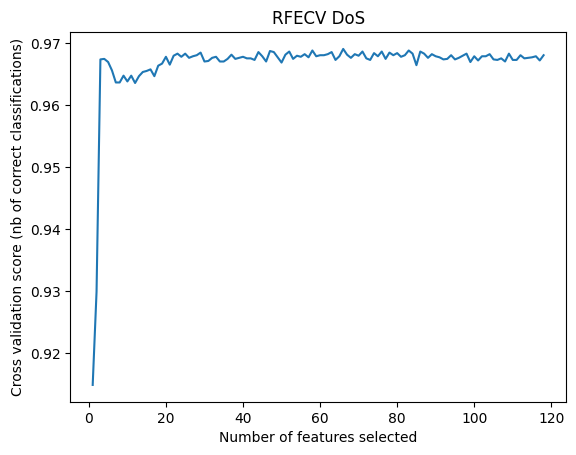

In [ ]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv_DoS = RFECV(estimator=clf_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test[:-1, :-1], Y_DoS_test[:-1])
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV DoS')
plt.plot(range(1, len(rfecv_DoS.cv_results_['mean_test_score']) + 1), rfecv_DoS.cv_results_['mean_test_score'])
plt.show()

# Using 13 Features for each category

# Confusion Matrices
## DoS

In [ ]:
# reduce test dataset to 13 features, use only features described in rfecolname_DoS etc.
X_DoS_test2=X_DoS_test[:,rfecolindex_DoS]
#X_Probe_test2=X_Probe_test[:,rfecolindex_Probe]
#X_R2L_test2=X_R2L_test[:,rfecolindex_R2L]
#X_U2R_test2=X_U2R_test[:,rfecolindex_U2R]
#X_U2R_test2.shape

In [ ]:
Y_DoS_pred2=clf_rfeDoS.predict(X_DoS_test2)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,1460,692
1,3341,6357


# Cross Validation: Accuracy, Precision, Recall, F-measure

## DoS

In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2[:-1, :-1], Y_DoS_test[:-1], cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeDoS, X_DoS_test2[:-1, :-1], Y_DoS_test[:-1], cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeDoS, X_DoS_test2[:-1, :-1], Y_DoS_test[:-1], cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeDoS, X_DoS_test2[:-1, :-1], Y_DoS_test[:-1], cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.96616 (+/- 0.00897)
Precision: 0.98019 (+/- 0.00880)
Recall: 0.97845 (+/- 0.00608)
F-measure: 0.97931 (+/- 0.00544)


# Stratified CV => Stays the same

In [ ]:
from sklearn.model_selection import StratifiedKFold
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2[:-1, :-1], Y_DoS_test[:-1], cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.96616 (+/- 0.00897)


# CV 2, 5, 10, 30, 50 fold

## DoS

In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2[:-1, :-1], Y_DoS_test[:-1], cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.96152 (+/- 0.00134)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.96439 (+/- 0.00935)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.96565 (+/- 0.00940)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.96338 (+/- 0.01231)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.96456 (+/- 0.01975)
